# FOMO - Faster Objects, More Objects

### Import modules

In [135]:
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision.transforms import Resize

### Constants

In [136]:
DATASET_DIR = Path('vehicle_detection_dataset')
IMAGE_RESOLUTION = int(1280 / 4)
GRID_SCALE = 8  # number of pixels per cell on grid (vertically and horizontally)
GRID_RESOLUTION = int(IMAGE_RESOLUTION / GRID_SCALE)

### Dataset and Dataloader

In [137]:
class VehicleDataset(Dataset):
    def __init__(self, dataset_dir: Path, subset: list[str], transform=None, target_transform=None):
        self._images = [dataset_dir / 'images' / (element + ".jpg") for element in subset]
        self._bounding_boxes = [dataset_dir / 'bounding_boxes' / (element + ".txt") for element in subset]
        self._transform = transform
        self._target_transform = target_transform  # TODO move target transform code to custom class, the same way as Resize()
    
    def __getitem__(self, idx: int):
        image_file = self._images[idx]
        image = read_image(str(image_file))
        image = self._transform(image)

        bounding_box_file = self._bounding_boxes[idx]
        mask = torch.zeros((GRID_RESOLUTION, GRID_RESOLUTION), dtype=int)  # 0 in that mask stands for background, next values represent corresponding classes
        with open(bounding_box_file) as bb_file:
            bounding_boxes = bb_file.readlines()
            for bounding_box in bounding_boxes:
                [c, x, y, w, h] = [float(coords) for coords in bounding_box.split()]  # get bounding box class, position and dimension
                xp = int((x + (w / 2)) * IMAGE_RESOLUTION)  # calculate center of bounding box
                yp = int((y + (h / 2)) * IMAGE_RESOLUTION)
                xp_idx = int(xp / GRID_SCALE)  # calculate cell coordinates, with center of bounding box 
                yp_idx = int(yp / GRID_SCALE)
                mask[yp_idx, xp_idx] = c + 1  # mark cell containing center of bounding box, with class value increased by 1

        return image, mask

    def __len__(self):
        return len(self._images)
    
transform = Resize((IMAGE_RESOLUTION, IMAGE_RESOLUTION))

data_names = sorted([data_name for data_name in (DATASET_DIR / 'images').iterdir()])
train_names, val_names = random_split(data_names, [0.85, 0.15]) 
train_dataset = VehicleDataset(DATASET_DIR, [data_names[idx].stem for idx in train_names.indices], transform)
val_dataset = VehicleDataset(DATASET_DIR, [data_names[idx].stem for idx in val_names.indices])
train_loader = DataLoader(train_dataset, 32)
val_loader = DataLoader(val_dataset, 32)

TESTS

In [140]:
data = next(iter(train_loader))

There are 6 objects in the picture


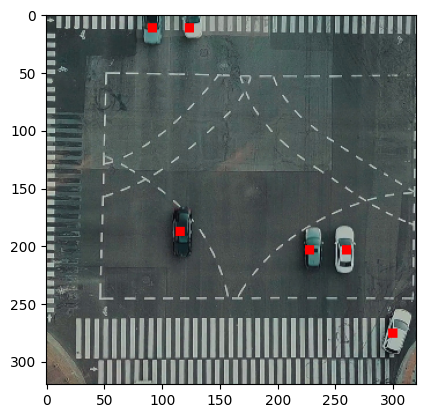

In [143]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

data_idx = 0
image = data[0][data_idx]
mask = data[1][data_idx]

image = image.permute(1, 2, 0).numpy()
mask = mask.numpy()

mask_res = cv2.resize(mask, dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION), interpolation=cv2.INTER_NEAREST)
image[mask_res == 1] = [255, 0, 0]
plt.imshow(image)

cnt = np.count_nonzero(mask == 1)
print("There are", str(cnt), "objects in the picture")